# ***** The notebook contains the driver code to train NN on MNIST dataset *****

The model used in this notebook consists of the 4 different steps (on top of Model_1) as one that were discussed in the session: <br>
   - Regularization
   - Global Average Pooling
   - Increasing Capacity
   - Correct MaxPooling Location


1. **Target**
     * Introduce regularization in the model using DROPOUT at each layer. [This reduces the overfitting in the model as the training accuracy has decreased and the gap between the traininga and testing accuracy has narrowed.]
     * Remove the last big kernel and introduce GAP layer followed by fully connected layer. [Due to reduction in number of parameters, both the accuracies have reduced.]
     * Insert capacity layer at the end before GAP to boost model capacity to learn complex patterns. [This increased the testing and training accuracy significanly.]
     * Add fully connected layers after GAP to increase model performance. [This increased the testing and training accuracy.]
     * Check and Correct(if) position of MaxPooling layer. [Position of MAXPOOL layer is at RF=5 and RF=14]


2. **Result**
     * Parameters: 7873
     * Best Training Accuracy: 99.10% (15th epoch)
     * Best Testing Accuracy: 99.26% (15th epoch)


3. **Analysis**
     * The model (Model_2) we have created for step2 with ~7.9k paramaters is overall a good model which is able to achieve 99.26% testing accuracy in 15 epochs.
     * From the training and testing accuracy achieved by the model, we can conclude that the model is not overfitting at all. [which is due to regularization].
     * If we push the current model further, there is scope left to reach the testing accuracy of 99.40%.
     * We now will need to add some image augmentation and play with lr to reach the goal of 99.4% testing accuracy.





## Code Block 1

In [ ]:
############################ Load required libraries ############################
import torch
from torchsummary import summary
import matplotlib.pyplot as plt

# Load Model configuration
from models import Model_2
# Load necessary functions
from utils import  *



################################ Hyperparamters ################################




# variables to store data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Define hyperparameters
batch_size = 256          # Define the batch size for data loading
lr = 0.01                 # Define learning rate value
momentum = 0.9            # Define momentum value
criterion_name = "nll_loss"       # Define criterion name
num_epochs = 15                   # Number of epochs for training
optimizer_algo = "SGD"            # Define optimizer name


# Create a dictionary of keyword arguments (kwargs) for DataLoader
kwargs = {
    'batch_size': batch_size,   # Set the batch size for each batch of data
    'shuffle': True,            # ensures that the model encounters a diverse mix of data during training, leading to better learning and generalization (during testing, the order of data doesn’t impact the model’s predictions)
    'num_workers': 2,           # Number of worker threads for data loading ( each worker will deal with batchsize/num_workers set of data under a batch) # parallel processing-> reduces overall time
    'pin_memory': True          # Enable pinning memory for faster GPU transfer
}

torch.manual_seed(4)

## Code Block 2

In [ ]:
# check if CUDA is available or not
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")       #setting the device on which computations will be executed
print("Device set to: ",device)

CUDA Available? True
Device set to:  cuda


In [ ]:
## see the source function
# get_MNISTdataset_with_loader??
Model_2()

Model_2(
  (convblock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 21, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(21, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(9, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    

## Code Block 3

In [ ]:
## Get MNIST dataset and pass it to loader

test_loader  = get_MNISTdataset_with_loader('test',2,kwargs)   # load test data
train_loader = get_MNISTdataset_with_loader('train',2,kwargs)  # load train data


Testing data loaded successfully...
Training data loaded successfully...


## Code Block 4

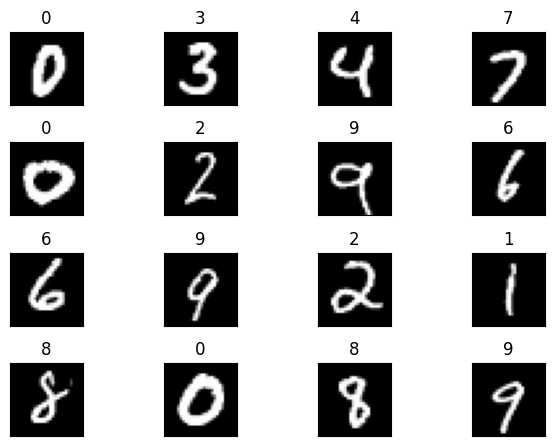

In [ ]:
################ Display a sample of data from the training dataset #####################
post_display(train_loader)

## Code Block 5

In [ ]:
# Initialize the model and move it to the device ( GPU )
model = Model_2().to(device)

#Get summary of model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 21, 24, 24]           1,890
              ReLU-5           [-1, 21, 24, 24]               0
       BatchNorm2d-6           [-1, 21, 24, 24]              42
           Dropout-7           [-1, 21, 24, 24]               0
            Conv2d-8            [-1, 9, 24, 24]             189
         MaxPool2d-9            [-1, 9, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]             972
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

In [ ]:
# get_optimizer??

## Code Block 6

In [ ]:
####################################################### Train Model#####################################################

# Set up the optimizer with stochastic gradient descent with learning rate and momentum
optimizer = get_optimizer(model,optimizer_algo, lr, momentum)

# Define the loss function as negative log likelihood loss.
criterion = get_loss(criterion_name)


print(f"The current learning rate is: {[lr]}")
# Loop over the dataset multiple times, once for each epoch
for epoch in range(1, num_epochs+1):
  # Print the current epoch number
  print(f'Epoch {epoch}')

  # Call the train function, passing in the model, device, data loader, optimizer, and loss function
  train(model, device, train_loader, optimizer, criterion,train_losses,train_acc)

  # After training, evaluate the model on the same training data loader (should be test_loader for evaluation)
  test(model, device, test_loader, criterion,test_losses,test_acc)  # Note: should ideally be test_loader



The current learning rate is: [0.01]
Epoch 1


Train: Loss=0.2361 Batch_id=234 Accuracy=72.42: 100%|██████████| 235/235 [00:19<00:00, 12.21it/s]


Test set: Average loss: 0.0006, Accuracy: 9629/10000 (96.29%)

Epoch 2


Train: Loss=0.0611 Batch_id=234 Accuracy=96.99: 100%|██████████| 235/235 [00:14<00:00, 16.19it/s]


Test set: Average loss: 0.0003, Accuracy: 9785/10000 (97.85%)

Epoch 3


Train: Loss=0.0221 Batch_id=234 Accuracy=97.93: 100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Test set: Average loss: 0.0002, Accuracy: 9848/10000 (98.48%)

Epoch 4


Train: Loss=0.0624 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:14<00:00, 15.88it/s]


Test set: Average loss: 0.0002, Accuracy: 9855/10000 (98.55%)

Epoch 5


Train: Loss=0.0174 Batch_id=234 Accuracy=98.52: 100%|██████████| 235/235 [00:15<00:00, 15.64it/s]


Test set: Average loss: 0.0002, Accuracy: 9877/10000 (98.77%)

Epoch 6


Train: Loss=0.0558 Batch_id=234 Accuracy=98.61: 100%|██████████| 235/235 [00:15<00:00, 14.79it/s]


Test set: Average loss: 0.0002, Accuracy: 9882/10000 (98.82%)

Epoch 7


Train: Loss=0.0372 Batch_id=234 Accuracy=98.75: 100%|██████████| 235/235 [00:14<00:00, 15.90it/s]


Test set: Average loss: 0.0002, Accuracy: 9899/10000 (98.99%)

Epoch 8


Train: Loss=0.0218 Batch_id=234 Accuracy=98.79: 100%|██████████| 235/235 [00:15<00:00, 14.80it/s]


Test set: Average loss: 0.0001, Accuracy: 9915/10000 (99.15%)

Epoch 9


Train: Loss=0.0370 Batch_id=234 Accuracy=98.88: 100%|██████████| 235/235 [00:14<00:00, 15.78it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Epoch 10


Train: Loss=0.0842 Batch_id=234 Accuracy=98.85: 100%|██████████| 235/235 [00:14<00:00, 15.84it/s]


Test set: Average loss: 0.0001, Accuracy: 9900/10000 (99.00%)

Epoch 11


Train: Loss=0.0308 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:15<00:00, 15.47it/s]


Test set: Average loss: 0.0001, Accuracy: 9918/10000 (99.18%)

Epoch 12


Train: Loss=0.0767 Batch_id=234 Accuracy=98.94: 100%|██████████| 235/235 [00:14<00:00, 15.94it/s]


Test set: Average loss: 0.0001, Accuracy: 9921/10000 (99.21%)

Epoch 13


Train: Loss=0.0323 Batch_id=234 Accuracy=98.98: 100%|██████████| 235/235 [00:14<00:00, 15.95it/s]


Test set: Average loss: 0.0001, Accuracy: 9915/10000 (99.15%)

Epoch 14


Train: Loss=0.0469 Batch_id=234 Accuracy=99.06: 100%|██████████| 235/235 [00:15<00:00, 14.97it/s]


Test set: Average loss: 0.0001, Accuracy: 9925/10000 (99.25%)

Epoch 15


Train: Loss=0.0103 Batch_id=234 Accuracy=99.10: 100%|██████████| 235/235 [00:15<00:00, 15.65it/s]


Test set: Average loss: 0.0001, Accuracy: 9926/10000 (99.26%)



## Code Block 7

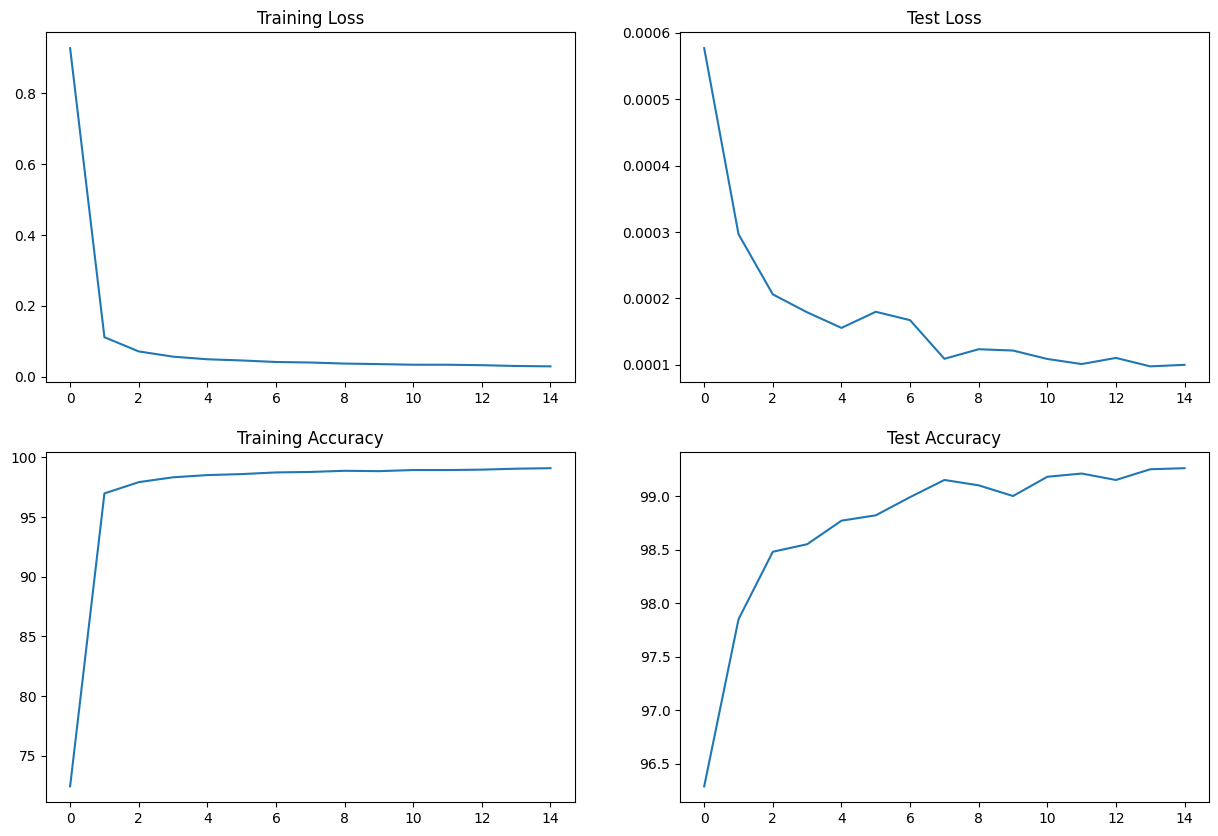

In [ ]:
# Plot accuracy and loss
post_accuracyplots(train_losses,test_losses,train_acc,test_acc)